# Clasificador por ensamble stacking 

## Importamos las librerias a utilizar

In [ ]:
import numpy as np 
import pandas as pd
import pickle
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

## Cargamos el df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

hotel = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/hotels_train.csv')
hotel_t = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/hotels_test.csv')
hotel_orig = hotel_t.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Analisis exploratorio

In [ ]:
hotel = hotel[hotel['adr']>0]
total_filas = hotel.shape[0]
hotel.shape

(61028, 32)

## Preprocesamiento

In [ ]:
hotel['children'].fillna(0,inplace = True)
hotel['country'].fillna('PRT',inplace = True)
hotel['agent'].fillna(0,inplace = True)
hotel['company'].fillna(0,inplace = True)
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date']
hotel.drop(columnas_eliminar, axis='columns', inplace=True)

hotel_t['children'].fillna(0,inplace = True)
hotel_t['country'].fillna('PRT',inplace = True)
hotel_t['agent'].fillna(0,inplace = True)
hotel_t['company'].fillna(0,inplace = True)
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date']
hotel_t.drop(columnas_eliminar, axis='columns', inplace=True)

In [ ]:
def higher_probability(a,b):
    if a == b:
        return 0
    else:
        return 1

hotel['hotel'] = hotel['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel['country'] = hotel['country'].apply(higher_probability,b='PTR')
hotel['market_segment'] = hotel['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel['distribution_channel'] = hotel['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
hotel['reserved_room_type'] = hotel['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel['assigned_room_type'] = hotel['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel['agent'] = hotel['agent'].apply(higher_probability,b=0)
hotel['company'] = hotel['company'].apply(higher_probability,b=0)


hotel_t['hotel'] = hotel_t['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel_t['arrival_date_month'] = hotel_t['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel_t['country'] = hotel_t['country'].apply(higher_probability,b='PTR')
hotel_t['market_segment'] = hotel_t['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel_t['distribution_channel'] = hotel_t['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
hotel_t['reserved_room_type'] = hotel_t['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel_t['assigned_room_type'] = hotel_t['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel_t['agent'] = hotel_t['agent'].apply(higher_probability,b=0)
hotel_t['company'] = hotel_t['company'].apply(higher_probability,b=0)

hotel.shape

(61028, 26)

In [ ]:
#Dummies para deposit_type
hotel = pd.get_dummies(hotel, columns=['deposit_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['deposit_type'], drop_first=True)

#Dummies para customer_type
hotel = pd.get_dummies(hotel, columns=['customer_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['customer_type'], drop_first=True)

## Entrenamiento y Prediccion

In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [ ]:
target='is_canceled'
hotel_x=hotel.drop([target], axis='columns', inplace=False)
hotel_y = hotel[target].copy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(hotel_x, 
                                                    hotel_y, 
                                                    test_size=0.20,    #20% al conjunto de test
                                                    random_state=42)  #para poder reproducir el experiment) 

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test) 

stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

In [ ]:
svm_linear = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/svm_linear", "rb"))
svm_pipeline = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/svm_pipeline", "rb"))
svm_rbf = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/svm_rbf", "rb"))
svm_poly = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/svm_poly", "rb"))
knn_minmax = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/knn_minmax", "rb"))
knn_norm = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/knn_norm", "rb"))
XGB_model = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/XGB_model", "rb"))
random_forest = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/random_forest.pickle", "rb"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer t

In [ ]:
#Modelos Base
base_models = {'svm_linear': svm_linear,
               'svm_pipeline': svm_pipeline,
               'svm_rbf': svm_rbf,
               'svm_poly': svm_poly,
               'knn_minmax': knn_minmax,
               'knn_norm': knn_norm,
               'XGB_model': XGB_model,
               'random_forest': random_forest,}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = f1_score(y_test,model.predict(x_test_minmax) )
    model_scores[name] = scores

Evaluating svm_linear
Evaluating svm_pipeline


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Evaluating svm_rbf
Evaluating svm_poly
Evaluating knn_minmax


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Evaluating knn_norm


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Evaluating XGB_model
Evaluating random_forest


In [ ]:
for key in model_scores:
    print(key," f1: ",model_scores[key])

svm_linear  f1:  0.7556131260794472
svm_pipeline  f1:  0.6950010119409027
svm_rbf  f1:  0.8029097133076595
svm_poly  f1:  0.7958819024929805
knn_minmax  f1:  0.0
knn_norm  f1:  0.0
XGB_model  f1:  0.10688801514489588
random_forest  f1:  0.4924475009210365


In [ ]:
from sklearn.ensemble import StackingClassifier
''' ('svm_pipeline', svm_pipeline), '''
base_models = [('svm_linear', svm_linear),
               ('svm_rbf', svm_rbf),
               ('svm_poly', svm_poly),
               ('knn_minmax', knn_minmax),
               ('knn_norm', knn_norm),
               ('XGB_model', XGB_model),
               ('random_forest', random_forest),]

meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
result = stacking_model.fit(x_train_minmax, y_train)
stacking_scores = f1_score(y_test,result.predict(x_test_minmax) )
model_scores['stacking'] = stacking_scores

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 

In [ ]:
for key in model_scores:
    print(key," f1: ",model_scores[key])

svm_linear  f1:  0.7556131260794472
svm_pipeline  f1:  0.6950010119409027
svm_rbf  f1:  0.8029097133076595
svm_poly  f1:  0.7958819024929805
knn_minmax  f1:  0.0
knn_norm  f1:  0.0
XGB_model  f1:  0.10688801514489588
random_forest  f1:  0.4924475009210365
stacking  f1:  0.8435656725097616


              precision    recall  f1-score   support

           0       0.83      0.86      0.85      6070
           1       0.86      0.83      0.84      6136

    accuracy                           0.85     12206
   macro avg       0.85      0.85      0.85     12206
weighted avg       0.85      0.85      0.85     12206



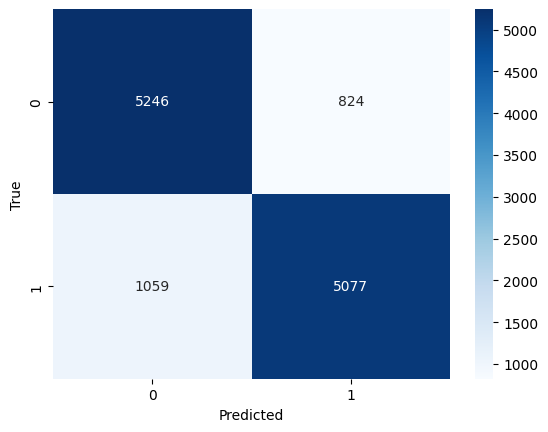

In [ ]:
#Evaluo en conjunto de test
pred = stacking_model.predict(x_test_minmax)
metricas(pred,y_test)

In [33]:
y_pred_test = stacking_model.predict(hotel_t)
entregable = pd.DataFrame({'id': hotel_orig['id'], 'is_canceled':pd.Series(y_pred_test).astype(int)})

entregable.head()
''' entregable.to_csv('staking_predictions.csv', index=False) '''

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


" entregable.to_csv('staking_predictions.csv', index=False) "